In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
# !pip install kaggle --upgrade

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [6]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [7]:
# ! conda install -y -c haasad eidl7zip

In [8]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

__Multiclass classification__

In [9]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
      .random_split_by_pct(0.2)
      .label_from_df(label_delim=' '))

In [12]:
src

LabelLists;

Train: LabelList (32384 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/jupyter/.fastai/data/planet;

Test: None

In [13]:
data = (src.transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

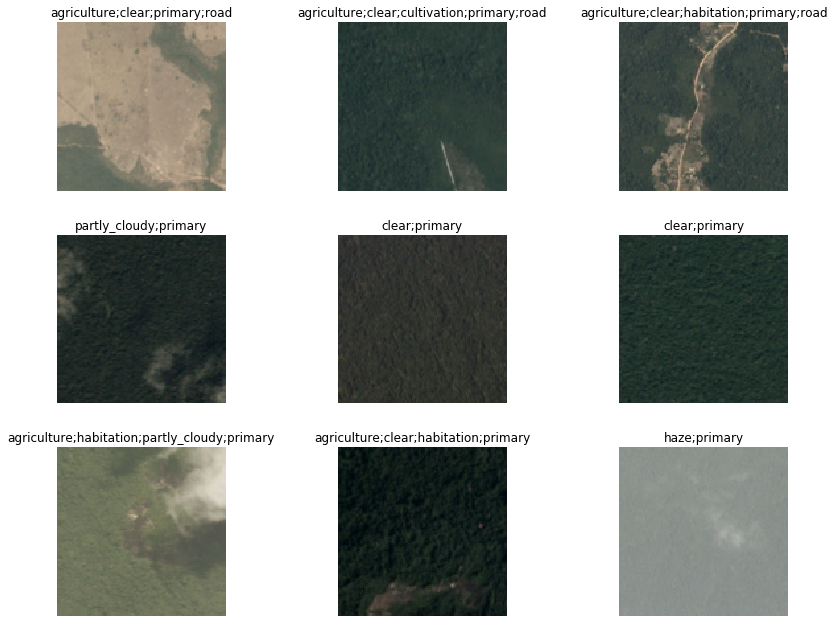

In [14]:
data.show_batch(rows=3, figsize=(12, 9))

In [15]:
arch = models.resnet50

In [16]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])


In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02


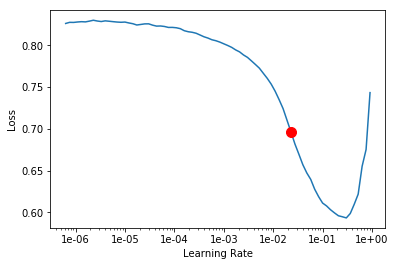

In [18]:
learn.recorder.plot()

In [19]:
lr = 0.01

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.123529,0.111554,0.945696,0.901911
2,0.111343,0.100875,0.953290,0.908210
3,0.101173,0.091043,0.952026,0.921521
4,0.092894,0.087569,0.956684,0.924385
5,0.091422,0.086541,0.956989,0.925743


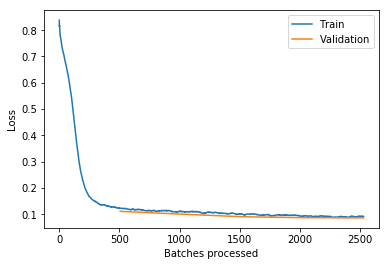

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-1-rn50')

In [23]:
learn.load('stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/jupyter/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06


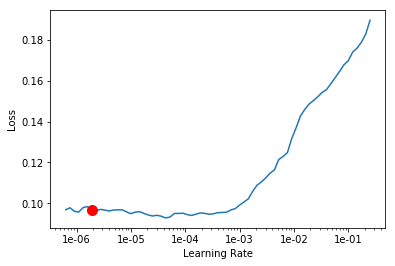

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.097949,0.091153,0.956153,0.920565
2,0.096179,0.089364,0.953297,0.922775
3,0.090880,0.085728,0.956538,0.926353
4,0.085738,0.082258,0.957425,0.927742
5,0.079465,0.082432,0.958973,0.928653


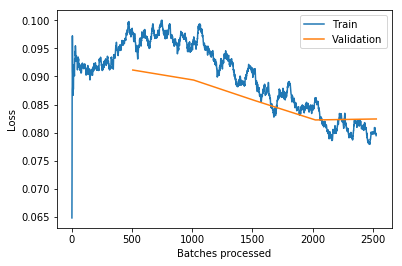

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save('stage-2-rn50')

In [30]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/jupyter/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_

In [31]:
data = (src.transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [32]:
learn.freeze()

In [33]:
learn.save('stage-0-256-rn50')

In [34]:
learn.load('stage-0-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/jupyter/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


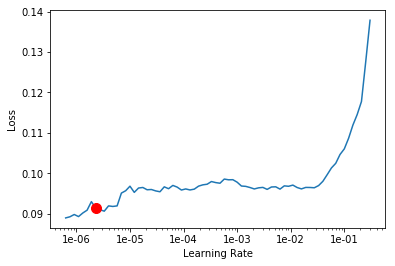

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
lr = 1e-2/2

In [37]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.086517,0.085578,0.959336,0.926714
2,0.088476,0.083165,0.959954,0.927117
3,0.084294,0.082551,0.957069,0.927957
4,0.081336,0.081455,0.958754,0.929594
5,0.079263,0.080763,0.958624,0.930251


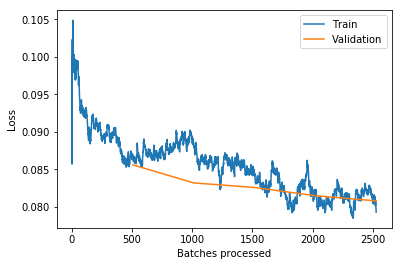

In [38]:
learn.recorder.plot_losses()

In [39]:
learn.save('stage-1-256-rn50')

In [40]:
learn.load('stage-1-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/jupyter/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_

In [41]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.083349,0.083187,0.956952,0.928344
2,0.086063,0.085087,0.957977,0.927312
3,0.084704,0.081393,0.958507,0.930340
4,0.076995,0.080576,0.958696,0.930124
5,0.076366,0.080425,0.960092,0.931298


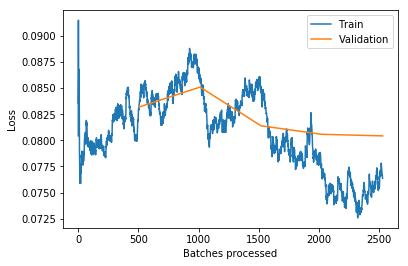

In [44]:
learn.recorder.plot_losses()

In [45]:
learn.save('stage-2-256-rn50')

In [46]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/jupyter/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_

In [47]:
learn.export()

In [21]:
# fin

In [22]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}
# ! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}


 98%|███████████████████████████████████████ | 589M/603M [00:07<00:00, 50.8MB/s]
100%|████████████████████████████████████████| 603M/603M [00:07<00:00, 81.1MB/s]
 97%|██████████████████████████████████████▉ | 296M/304M [00:05<00:00, 66.1MB/s]
100%|████████████████████████████████████████| 304M/304M [00:05<00:00, 54.5MB/s]


In [48]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/planet/models'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional'),
 PosixPath('/home/jupyter/.fastai/data/planet/submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/export.pkl'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/planet/__MACOSX'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg')]

In [49]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [50]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [52]:
labelled_preds[:5]

['clear primary',
 'artisinal_mine clear primary water',
 'clear primary',
 'clear primary',
 'clear primary']

In [53]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [54]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [55]:
df.to_csv(path/'submission.csv', index=False)

In [56]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|███████████████████████████████████████| 2.19M/2.19M [00:02<00:00, 850kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space